In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
import os, math
from PyEMD import EMD
from spectrum import aryule
from functools import reduce
import statsmodels.api as sm
%matplotlib inline

In [2]:
rawData = sio.loadmat("data.mat")
sampRate = 3e3
rpm = 60
bearFreq = 10*rpm/60
maxP = 300
windLeng = [2**4,2**5, 2**6, 2**7]
x=rawData["vib"][0]
N=len(x);
maxKurt = -10000
maxOptP = -10000

214


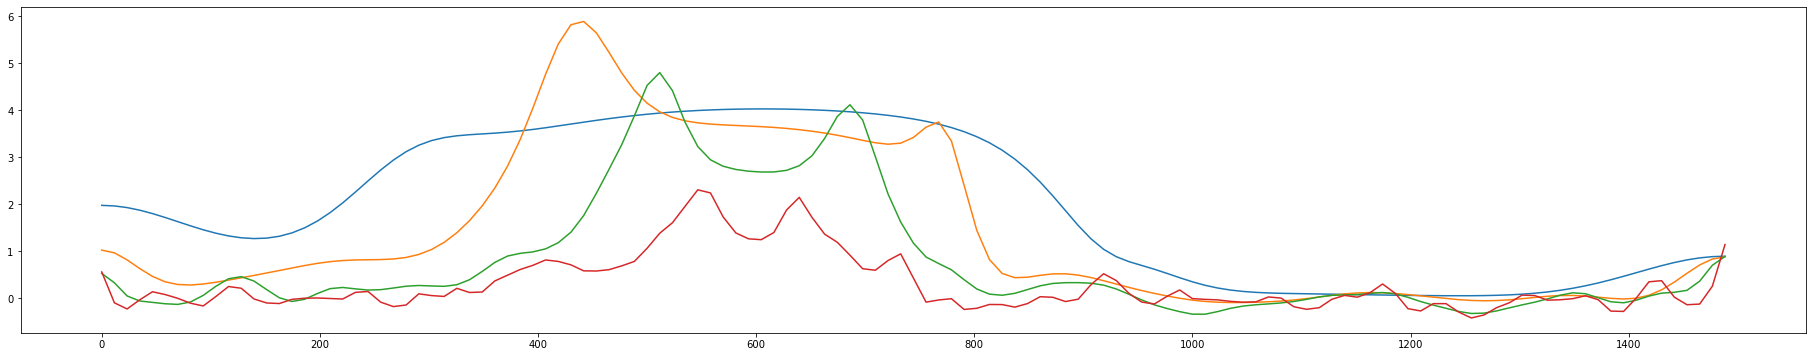

In [10]:
for p in range(1, maxP+1): 
#     a, _ = sm.regression.linear_model.yule_walker(x, p)
    a, _, _ = aryule(x, p)
    X = np.zeros((N,p));
    for i in range(p):
        X[i+1:, i] = x[:N-i-1]
    xp = - np.matmul(X , a)
    e = x - xp
    k = sp.stats.kurtosis(e[p+1:])
    if k > maxKurt:
        maxKurt = k
        maxOptP = p
print(maxOptP)
# optA, _, _ = sm.regression.linear_model.yule_walker(x, maxOptP)
optA, _, _ = aryule(x, maxOptP)
xp = sp.signal.lfilter(-optA, 1, x)
e = x[maxOptP:] - xp[maxOptP:]
Ne = len(e)
numFreq = np.max(windLeng) + 1
specKurt = []
for i in range(len(windLeng)):
    windFunc = sp.signal.windows.hann(windLeng[i])
    numOverlap = int(windLeng[i]/2); 
    numWind = int((Ne-numOverlap)/(windLeng[i]-numOverlap))
    a,b = 0, windLeng[i]
    STFT = np.zeros((numWind,numFreq));
    for t in range(numWind): 
        stft = np.fft.fft(e[a:b] * windFunc, 2*(numFreq-1));        
        stft = np.abs(stft[:numFreq])/windLeng[i]/np.sqrt(np.mean(windFunc**2))*2
        STFT[t,:] = np.transpose(stft)
        a = a + (windLeng[i]-numOverlap)
        b = b + (windLeng[i]-numOverlap)
    kurt = []
    for j in  range(numFreq):
        kurt.append(np.mean(np.abs(STFT[:,j])**4)/np.mean(np.abs(STFT[:,j])**2)**2-2)
    specKurt.append(kurt)
plt.figure(figsize=(32,6))
freq = np.arange(0, numFreq)/(2 * numFreq) * sampRate
for i in range(len(specKurt)):
    plt.plot(freq, specKurt[i])
# [freqRang] = input('Range of bandpass filtering, [freq1,freq2] = '); 
# [b,a] = butter(2,[freqRang(1) freqRang(2)]/(sampRate/2),'bandpass');
# X = filter(b,a,e);                                             % band-passed signal


# aX = hilbert(X); % hilbert(x) returns an analytic signal of x
# envel = abs(aX);                                          
# envel=envel-mean(envel);                                         % envelope signal
# fftEnvel = abs(fft(envel))/Ne*2;
# fftEnvel = fftEnvel(1:ceil(N/2));
# figure(2)                                                           %==== Result plot
# freq = (0:Ne-1)/Ne*sampRate;
# freq = freq(1:ceil(N/2));
# stem(freq,fftEnvel,'LineWidth',2); hold on; 
# [xx,yy]=meshgrid(bearFreq,ylim);
# plot(xx(:,1),yy(:,1),'*-')
# % plot(xx(:,1),yy(:,1),'x-',xx(:,2),yy(:,2),'d-',xx(:,3),yy(:,3),'^-')
# legend('Envelope spectrum','BPFO','BPFI','FTF','BSF');
# xlabel('Frequency [Hz]'); ylabel('Amplitude'); xlim([0 max(bearFreq)*1.8])